# Roles Classifier

The model implemented here follows the following architecture diagram:

![Roles Classifier Architecture](assets/roles.classifier.architecture.png)

We start with the import declarations:

In [1]:
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from BiLstmClassifier import BiLstmFixedLength, BiLstmVariableLength, BiLstmGloveVector

import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn.functional as F

## 0. Hyper Parameters Definition
Defining the correct hyper-parameters to refine the performance of the model is very important. We must consider some
situations around the values to be assigned.

### 0.1 Epochs
We must define a correct number of epochs to allow the model to learn from the dataset. If this is to few, the model
will not learn anything, if the value is too high, we can fall into over-fitting or wasting processing time where the
model can't learn anymore.

### 0.2 Batch Size
It defines the amount of data for each batch to be used on each training epoch. Because we have no much data, the value
here is small.

### 0.3 Embedded Layer Dimension
Word embeddings are always around 50 and 300 in length, longer embedding vectors don't add enough information and
smaller ones don't represent the semantics well enough. For this model, we are using small sentences for most of the
cases.

### 0.4 Hidden Layer Dimension
This parameter represents how complex is the language used in the conversations. For example, if the sentences belong
to a literature book from Shakespeare, it probably will use a sophisticated language, and we can assign a value of 70.
On the other hand, if the sentences belong to simple chat talking about movies, it is maybe simpler, and we can assign
a value of 30.


In [2]:
EPOCHS = 100
BATCH_SIZE = 100  # Small batches because the dataset is not bigger than 500 rows
HIDDEN_LAYER_DIM = 60  # AOLME is not too complex language, it represents the language's features
EMBEDDED_LAYER_DIM = 50

## 1. Load dataset

We are going to use the dataset generated by the Jupyter Notebook ["AOLME Datasets Generator"](main.ipynb)

In [3]:
roles = pd.read_csv('output/balanced_372.csv')
print(f'Dataset Size: {roles.shape}\n')
print(roles.head())

Dataset Size: (372, 2)

      Role                           Text
0  Student          you like how its like
1  Student  its like youre obsessed with 
2  Student                   and this one
3  Student                             no
4  Student           i dont like summary 


## 2. Pre-Processing
### 2.1. Mapping 'Roles' labels to numbers for vectorization

In [4]:
mapping = {'Student': 0, 'Co-Facilitator': 1, 'Facilitator': 2}
roles['Role'] = roles['Role'].apply(lambda x: mapping[x])
roles.head()


# Load English words model package
tok = spacy.load('en')


def tokenize(text: str):
    """
    This method tokenizes a sentence, considering the text is already lowered,
    ASCII, and  punctuation has been removed
    :param text: The sentence to be tokenized
    :return: A list containing each word of the sentence
    """
    return [token.text for token in tok.tokenizer(text)]


### 2.2. Dataset cleaning and Sentence Vectorizing
<a id='encode_sentence'></a>

In [5]:
# Count number of occurrences of each word
counts = Counter()
for index, row in roles.iterrows():
    counts.update(tokenize(row['Text']))

# Deletes words appearing only once
print(f'Number of Words before cleaning: {len(counts.keys())}')
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print(f'Number of Words after cleaning: {len(counts.keys())}\n')

# Creates vocabulary
vocab2index = {'': 0, 'UNK': 1}
words = ['', 'UNK']
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)


def encode_sentence(text, vocabulary_map, n=70):
    """
    Encodes the sentence into a numerical vector, based on the vocabulary map
    :param text: The sentence
    :param vocabulary_map: A map assigning a number to each word in the vocabulary
    :param n: Required vector size
    :return: Vectorized sentence and length
    """
    tokenized = tokenize(text)
    vectorized = np.zeros(n, dtype=int)
    enc1 = np.array([vocabulary_map.get(w, vocabulary_map["UNK"]) for w in tokenized])
    length = min(n, len(enc1))
    vectorized[:length] = enc1[:length]
    return vectorized, length


# Creates a new column into Dataset: each sentence expressed as a numeric vector
roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))
print(roles.head())

Number of Words before cleaning: 662
Number of Words after cleaning: 347

   Role                           Text  \
0     0          you like how its like   
1     0  its like youre obsessed with    
2     0                   and this one   
3     0                             no   
4     0           i dont like summary    

                                          Vectorized  
0  [[2, 3, 4, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[5, 3, 2, 1, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
4  [[11, 12, 13, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  


<ipython-input-5-5b2887f873d4>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


Check if the dataset is balanced

In [6]:
Counter(roles['Role'])

Counter({0: 124, 1: 124, 2: 124})

### 2.3 Split into training and validation partitions


In [7]:
X = list(roles['Vectorized'])
y = list(roles['Role'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)


class RolesDataset(Dataset):
    """
    Simple PyTorch Dataset wrapper defined by an array of vectorized sentences (X) and the role for each sentence (y)
    """
    def __init__(self, input_x, input_y):
        self.X = input_x
        self.y = input_y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]


training_ds = RolesDataset(X_train, y_train)
validation_ds = RolesDataset(X_valid, y_valid)

### 2.4 Training and Validation Functions

In [8]:
def train_model(input_model, epochs=10, lr=0.001, verbose=True):
    """
    Trains the input model
    :param verbose: Prints each batch iteration
    :param input_model: Input Model
    :param epochs: The number of training epochs
    :param lr: Learning Rate
    :return: training loss, validation loss, validation accuracy, and validation RMSE
    """
    parameters = filter(lambda p: p.requires_grad, input_model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    for i in range(epochs):
        input_model.train()
        sum_loss = 0.0
        total = 0

        # Iterates on Training DataLoader
        for x, y, l in training_dl:
            x = x.long()
            y = y.long()
            y_pred = input_model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * y.shape[0]
            total += y.shape[0]

        val_loss, val_acc, val_rmse = get_metrics(input_model, validation_dl)

        if verbose and (i + 1) % 20 == 1:
            print(f"Epoch {i}: training loss %.3f, valid. loss %.3f, valid. accuracy %.3f, and valid. RMSE %.3f" % (
                sum_loss / total, val_loss, val_acc, val_rmse))

    print(f"FINAL: training loss %.3f, valid. loss %.3f, valid. accuracy %.3f, and valid. RMSE %.3f" % (
        sum_loss / total, val_loss, val_acc, val_rmse))

    return sum_loss / total, val_loss, val_acc, val_rmse


def get_metrics(input_model, valid_dl):
    """
    Obtains current validation metrics
    :param input_model: Input Model
    :param valid_dl: Validation PyTorch DataLoader
    :return:
    """
    input_model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0

    # PyTorch uses CrossEntropy function to implement Softmax on the same function
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = input_model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item() * y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1))) * y.shape[0]
    return sum_loss / total, correct / total, sum_rmse / total

In [9]:
vocab_size = len(words)
training_dl = DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size=BATCH_SIZE)

## BiLSTM - Fixed Length Input

We can see the implemented model class in [BiLstmClassifier class](BiLstmClassifier.py).

<b>BiLstmFixedLength</b> has the following features:

- Word-Embedding Layer. # Embeddings: Vocabulary Size, Embeddings size: 50
- Bi-directional LSTM Layer. Input size: 50, Hidden size: 60
- Linear Layer. Fully connected layer, Input size: 60, 3 output features (roles)
- Dropout: 0.7
- Fixed Length Input (see [encode_sentence](#encode_sentence) function)

In [10]:
model_fixed = BiLstmFixedLength(vocab_size, EMBEDDED_LAYER_DIM, HIDDEN_LAYER_DIM)

print(f'\nBiLSTM - Fixed Length: {EPOCHS} epochs, Learning Rate: 0.1')
print('=============================================================')
train_model(model_fixed, epochs=EPOCHS, lr=0.1)
print(f'\nBiLSTM - Fixed Length: {EPOCHS} epochs, Learning Rate: 0.05')
print('=============================================================')
train_model(model_fixed, epochs=EPOCHS, lr=0.05)
print(f'\nBiLSTM - Fixed Length: {EPOCHS} epochs, Learning Rate: 0.01')
print('=============================================================')
train_model(model_fixed, epochs=EPOCHS, lr=0.01)


BiLSTM - Fixed Length: 100 epochs, Learning Rate: 0.1
Epoch 0: training loss 1.165, valid. loss 1.175, valid. accuracy 0.387, and valid. RMSE 0.966
Epoch 20: training loss 0.891, valid. loss 1.253, valid. accuracy 0.493, and valid. RMSE 1.089
Epoch 40: training loss 0.932, valid. loss 1.397, valid. accuracy 0.413, and valid. RMSE 1.178
Epoch 60: training loss 0.938, valid. loss 1.162, valid. accuracy 0.507, and valid. RMSE 1.007
Epoch 80: training loss 0.850, valid. loss 1.254, valid. accuracy 0.480, and valid. RMSE 1.058
FINAL: training loss 0.849, valid. loss 1.153, valid. accuracy 0.547, and valid. RMSE 1.046

BiLSTM - Fixed Length: 100 epochs, Learning Rate: 0.05
Epoch 0: training loss 0.881, valid. loss 1.226, valid. accuracy 0.493, and valid. RMSE 1.071
Epoch 20: training loss 0.822, valid. loss 1.140, valid. accuracy 0.520, and valid. RMSE 1.039
Epoch 40: training loss 0.821, valid. loss 1.309, valid. accuracy 0.440, and valid. RMSE 1.114
Epoch 60: training loss 0.811, valid. l

(0.6764025961108481, 1.4484089612960815, tensor(0.5467), 1.0066445913694333)

## BiLSTM - Variable Length Input

We can see the implemented model class in [BiLstmClassifier class](BiLstmClassifier.py).

<b>BiLstmVariableLength</b> has the following features:

- Word-Embedding Layer. # Embeddings: Vocabulary Size, Embeddings size: 50
- Bi-directional LSTM Layer. Input size: 50, Hidden size: 60
- Linear Layer. Fully connected layer, Input size: 60, 3 output features (roles)
- Dropout: 0.7
- Variable Length Input. Uses PyTorch's [pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) to create sequences of variable length.

In [11]:
model = BiLstmVariableLength(vocab_size, EMBEDDED_LAYER_DIM, HIDDEN_LAYER_DIM)

print(f'\nBiLSTM - Variable Length: {EPOCHS} epochs, Learning Rate: 0.1')
print('=============================================================')
train_model(model, epochs=EPOCHS, lr=0.1)
print(f'\nBiLSTM - Variable Length: {EPOCHS} epochs, Learning Rate: 0.05')
print('=============================================================')
train_model(model, epochs=EPOCHS, lr=0.05)
print(f'\nBiLSTM - Variable Length: {EPOCHS} epochs, Learning Rate: 0.01')
print('=============================================================')
train_model(model, epochs=EPOCHS, lr=0.01)


BiLSTM - Variable Length: 100 epochs, Learning Rate: 0.1
Epoch 0: training loss 1.177, valid. loss 1.078, valid. accuracy 0.413, and valid. RMSE 1.178
Epoch 20: training loss 0.850, valid. loss 1.276, valid. accuracy 0.507, and valid. RMSE 0.987
Epoch 40: training loss 0.799, valid. loss 1.052, valid. accuracy 0.560, and valid. RMSE 0.980
Epoch 60: training loss 0.783, valid. loss 1.288, valid. accuracy 0.493, and valid. RMSE 0.952
Epoch 80: training loss 0.869, valid. loss 1.179, valid. accuracy 0.493, and valid. RMSE 0.931
FINAL: training loss 0.816, valid. loss 1.214, valid. accuracy 0.467, and valid. RMSE 0.987

BiLSTM - Variable Length: 100 epochs, Learning Rate: 0.05
Epoch 0: training loss 0.821, valid. loss 1.164, valid. accuracy 0.493, and valid. RMSE 0.973
Epoch 20: training loss 0.690, valid. loss 1.136, valid. accuracy 0.533, and valid. RMSE 1.033
Epoch 40: training loss 0.803, valid. loss 1.163, valid. accuracy 0.507, and valid. RMSE 0.987
Epoch 60: training loss 0.620, va

(0.6716712956075315, 1.2774460315704346, tensor(0.5467), 0.9451631252505217)

## BiLSTM - with pretrained GloVe Word Embeddings

We can see the implemented model class in [BiLstmClassifier class](BiLstmClassifier.py).

<b>BiLstmGloveVector</b> has the following features:

- Word-Embedding Layer. # Embeddings: Vocabulary Size, Embeddings size: 50
- Bi-directional LSTM Layer. Input size: 50, Hidden size: 60
- Linear Layer. Fully connected layer, Input size: 60, 3 output features (roles)
- Dropout: 0.7
- Uses pretrained GloVe Word Embeddings to initialize weights based on its vocabulary.

In [12]:
def load_glove_vectors():
    """Load the glove Global Vectors for Word Representation"""
    word_vectors = {}

    with open("./glove/glove.6B.50d.txt", encoding="utf8") as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors


def get_embedding_matrix(word_counts, emb_size=50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32')  # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size)  # adding a vector for unknown words
    vocab_to_idx["UNK"] = 1
    i = 2

    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25, 0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1
    return W, np.array(vocab), vocab_to_idx

In [13]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_embedding_matrix(counts, EMBEDDED_LAYER_DIM)

model = BiLstmGloveVector(vocab_size, EMBEDDED_LAYER_DIM, HIDDEN_LAYER_DIM, pretrained_weights)

print(f'\nBiLSTM - with pretrained GloVe Word Embeddings: {EPOCHS} epochs, Learning Rate: 0.1')
print('====================================================================================')
train_model(model, epochs=EPOCHS, lr=0.1)
print(f'\nBiLSTM - with pretrained GloVe Word Embeddings: {EPOCHS} epochs, Learning Rate: 0.05')
print('====================================================================================')
train_model(model, epochs=EPOCHS, lr=0.05)
print(f'\nBiLSTM - with pretrained GloVe Word Embeddings: {EPOCHS} epochs, Learning Rate: 0.01')
print('====================================================================================')
train_model(model, epochs=EPOCHS, lr=0.01)


BiLSTM - with pretrained GloVe Word Embeddings: 100 epochs, Learning Rate: 0.1
Epoch 0: training loss 1.578, valid. loss 1.187, valid. accuracy 0.293, and valid. RMSE 0.864
Epoch 20: training loss 1.008, valid. loss 1.108, valid. accuracy 0.440, and valid. RMSE 1.020
Epoch 40: training loss 0.987, valid. loss 1.173, valid. accuracy 0.387, and valid. RMSE 1.137
Epoch 60: training loss 0.983, valid. loss 1.077, valid. accuracy 0.467, and valid. RMSE 0.987
Epoch 80: training loss 0.951, valid. loss 1.132, valid. accuracy 0.467, and valid. RMSE 0.966
FINAL: training loss 0.937, valid. loss 1.130, valid. accuracy 0.347, and valid. RMSE 1.189

BiLSTM - with pretrained GloVe Word Embeddings: 100 epochs, Learning Rate: 0.05
Epoch 0: training loss 1.029, valid. loss 1.159, valid. accuracy 0.360, and valid. RMSE 1.166
Epoch 20: training loss 0.971, valid. loss 1.107, valid. accuracy 0.427, and valid. RMSE 1.065
Epoch 40: training loss 0.957, valid. loss 1.206, valid. accuracy 0.360, and valid. 

(0.9062143090598109, 1.1148595809936523, tensor(0.4400), 1.1489125293076057)

## Testing Several Files

In [14]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

file_size = [150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 645]
accuracy_fixed = []
accuracy_variable = []
accuracy_glove = []

for i in file_size:
    BATCH_SIZE = int(i * 0.5)
    file_name = f'output/balanced_{i}.csv'
    roles = pd.read_csv(file_name)
    mapping = {'Student': 0, 'Co-Facilitator': 1, 'Facilitator': 2}
    roles['Role'] = roles['Role'].apply(lambda x: mapping[x])
    counts = Counter()

    for index, row in roles.iterrows():
        counts.update(tokenize(row['Text']))

    for word in list(counts):
        if counts[word] < 2:
            del counts[word]

    vocab2index = {'': 0, 'UNK': 1}
    words = ['', 'UNK']
    for word in counts:
        vocab2index[word] = len(words)
        words.append(word)

    roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))

    X = list(roles['Vectorized'])
    y = list(roles['Role'])
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

    training_ds = RolesDataset(X_train, y_train)
    validation_ds = RolesDataset(X_valid, y_valid)

    vocab_size = len(words)
    training_dl = DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True)
    validation_dl = DataLoader(validation_ds, batch_size=BATCH_SIZE)

    print('\n********************************************')
    print(f'* Processing file: {file_name} *')
    print('********************************************')

    print(f'\nBiLSTM - Fixed Length Input')
    print('===========================')
    model_fixed = BiLstmFixedLength(vocab_size, EMBEDDED_LAYER_DIM, HIDDEN_LAYER_DIM)
    train_model(model_fixed, epochs=EPOCHS, lr=0.1, verbose=False)
    train_model(model_fixed, epochs=EPOCHS, lr=0.05, verbose=False)
    _, _, validation_accuracy, _ = train_model(model_fixed, epochs=EPOCHS, lr=0.01, verbose=False)
    accuracy_fixed.append(validation_accuracy)

    print(f'\nBiLSTM - Variable Length Input')
    print('==============================')
    model_varaiable = BiLstmVariableLength(vocab_size, EMBEDDED_LAYER_DIM, HIDDEN_LAYER_DIM)
    train_model(model_varaiable, epochs=EPOCHS, lr=0.1, verbose=False)
    train_model(model_varaiable, epochs=EPOCHS, lr=0.05, verbose=False)
    _, _, validation_accuracy, _ = train_model(model_varaiable, epochs=EPOCHS, lr=0.01, verbose=False)
    accuracy_variable.append(validation_accuracy)

    print(f'\nBiLSTM - with pretrained GloVe Word Embeddings')
    print('==============================================')
    word_vecs = load_glove_vectors()
    pretrained_weights, vocab, vocab2index = get_embedding_matrix(counts, EMBEDDED_LAYER_DIM)
    model = BiLstmGloveVector(vocab_size, EMBEDDED_LAYER_DIM, HIDDEN_LAYER_DIM, pretrained_weights)
    train_model(model, epochs=EPOCHS, lr=0.1, verbose=False)
    train_model(model, epochs=EPOCHS, lr=0.05, verbose=False)
    _, _, validation_accuracy, _ = train_model(model, epochs=EPOCHS, lr=0.01, verbose=False)
    accuracy_glove.append(validation_accuracy)



********************************************
* Processing file: output/balanced_150.csv *
********************************************

BiLSTM - Fixed Length Input


<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.642, valid. loss 1.476, valid. accuracy 0.467, and valid. RMSE 1.197
FINAL: training loss 0.479, valid. loss 1.089, valid. accuracy 0.567, and valid. RMSE 1.065
FINAL: training loss 0.574, valid. loss 1.001, valid. accuracy 0.600, and valid. RMSE 1.049

BiLSTM - Variable Length Input
FINAL: training loss 0.778, valid. loss 1.115, valid. accuracy 0.567, and valid. RMSE 0.966
FINAL: training loss 0.454, valid. loss 1.033, valid. accuracy 0.533, and valid. RMSE 0.983
FINAL: training loss 0.525, valid. loss 1.142, valid. accuracy 0.633, and valid. RMSE 0.983

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 1.065, valid. loss 0.969, valid. accuracy 0.567, and valid. RMSE 0.966
FINAL: training loss 0.753, valid. loss 1.019, valid. accuracy 0.467, and valid. RMSE 1.197
FINAL: training loss 0.657, valid. loss 0.882, valid. accuracy 0.533, and valid. RMSE 1.211

********************************************
* Processing file: output/balanced_200.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.718, valid. loss 1.525, valid. accuracy 0.525, and valid. RMSE 0.922
FINAL: training loss 0.601, valid. loss 1.872, valid. accuracy 0.325, and valid. RMSE 1.129
FINAL: training loss 0.549, valid. loss 1.735, valid. accuracy 0.375, and valid. RMSE 1.107

BiLSTM - Variable Length Input
FINAL: training loss 0.634, valid. loss 1.933, valid. accuracy 0.525, and valid. RMSE 0.962
FINAL: training loss 0.359, valid. loss 1.898, valid. accuracy 0.575, and valid. RMSE 0.758
FINAL: training loss 0.346, valid. loss 1.992, valid. accuracy 0.500, and valid. RMSE 0.935

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.780, valid. loss 1.341, valid. accuracy 0.350, and valid. RMSE 1.245
FINAL: training loss 0.618, valid. loss 1.741, valid. accuracy 0.350, and valid. RMSE 1.275
FINAL: training loss 0.552, valid. loss 1.881, valid. accuracy 0.375, and valid. RMSE 1.265

********************************************
* Processing file: output/balanced_250.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.634, valid. loss 1.628, valid. accuracy 0.540, and valid. RMSE 1.000
FINAL: training loss 0.715, valid. loss 1.574, valid. accuracy 0.540, and valid. RMSE 0.938
FINAL: training loss 0.493, valid. loss 1.622, valid. accuracy 0.500, and valid. RMSE 0.927

BiLSTM - Variable Length Input
FINAL: training loss 0.731, valid. loss 1.609, valid. accuracy 0.500, and valid. RMSE 0.927
FINAL: training loss 0.566, valid. loss 1.770, valid. accuracy 0.560, and valid. RMSE 0.894
FINAL: training loss 0.499, valid. loss 1.560, valid. accuracy 0.540, and valid. RMSE 0.872

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 1.048, valid. loss 1.213, valid. accuracy 0.400, and valid. RMSE 1.122
FINAL: training loss 0.885, valid. loss 1.335, valid. accuracy 0.420, and valid. RMSE 0.970
FINAL: training loss 0.746, valid. loss 1.319, valid. accuracy 0.440, and valid. RMSE 0.959

********************************************
* Processing file: output/balanced_300.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.675, valid. loss 1.684, valid. accuracy 0.400, and valid. RMSE 1.095
FINAL: training loss 0.568, valid. loss 1.770, valid. accuracy 0.517, and valid. RMSE 0.966
FINAL: training loss 0.514, valid. loss 1.676, valid. accuracy 0.483, and valid. RMSE 0.983

BiLSTM - Variable Length Input
FINAL: training loss 0.729, valid. loss 1.507, valid. accuracy 0.517, and valid. RMSE 1.017
FINAL: training loss 0.559, valid. loss 1.502, valid. accuracy 0.533, and valid. RMSE 0.957
FINAL: training loss 0.544, valid. loss 1.340, valid. accuracy 0.550, and valid. RMSE 0.922

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.837, valid. loss 1.245, valid. accuracy 0.400, and valid. RMSE 1.049
FINAL: training loss 0.802, valid. loss 1.149, valid. accuracy 0.450, and valid. RMSE 1.095
FINAL: training loss 0.754, valid. loss 1.169, valid. accuracy 0.483, and valid. RMSE 1.080

********************************************
* Processing file: output/balanced_350.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.717, valid. loss 1.390, valid. accuracy 0.414, and valid. RMSE 1.028
FINAL: training loss 0.667, valid. loss 1.442, valid. accuracy 0.429, and valid. RMSE 1.021
FINAL: training loss 0.603, valid. loss 1.391, valid. accuracy 0.457, and valid. RMSE 0.986

BiLSTM - Variable Length Input
FINAL: training loss 0.801, valid. loss 1.785, valid. accuracy 0.471, and valid. RMSE 0.978
FINAL: training loss 0.631, valid. loss 1.485, valid. accuracy 0.500, and valid. RMSE 0.894
FINAL: training loss 0.567, valid. loss 1.449, valid. accuracy 0.557, and valid. RMSE 0.837

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 1.118, valid. loss 1.325, valid. accuracy 0.471, and valid. RMSE 0.956
FINAL: training loss 0.802, valid. loss 1.223, valid. accuracy 0.471, and valid. RMSE 0.934
FINAL: training loss 0.793, valid. loss 1.213, valid. accuracy 0.514, and valid. RMSE 0.837

********************************************
* Processing file: output/balanced_400.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.773, valid. loss 1.366, valid. accuracy 0.438, and valid. RMSE 0.987
FINAL: training loss 0.701, valid. loss 1.322, valid. accuracy 0.500, and valid. RMSE 1.031
FINAL: training loss 0.600, valid. loss 1.325, valid. accuracy 0.512, and valid. RMSE 0.908

BiLSTM - Variable Length Input
FINAL: training loss 0.760, valid. loss 1.408, valid. accuracy 0.550, and valid. RMSE 0.822
FINAL: training loss 0.617, valid. loss 1.529, valid. accuracy 0.525, and valid. RMSE 0.859
FINAL: training loss 0.605, valid. loss 1.471, valid. accuracy 0.550, and valid. RMSE 0.844

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.950, valid. loss 1.059, valid. accuracy 0.500, and valid. RMSE 0.873
FINAL: training loss 0.878, valid. loss 1.089, valid. accuracy 0.450, and valid. RMSE 0.962
FINAL: training loss 0.794, valid. loss 1.087, valid. accuracy 0.512, and valid. RMSE 0.908

********************************************
* Processing file: output/balanced_450.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.784, valid. loss 1.102, valid. accuracy 0.578, and valid. RMSE 0.869
FINAL: training loss 0.688, valid. loss 1.113, valid. accuracy 0.567, and valid. RMSE 0.931
FINAL: training loss 0.643, valid. loss 1.126, valid. accuracy 0.600, and valid. RMSE 0.876

BiLSTM - Variable Length Input
FINAL: training loss 0.759, valid. loss 1.156, valid. accuracy 0.556, and valid. RMSE 0.882
FINAL: training loss 0.597, valid. loss 0.991, valid. accuracy 0.633, and valid. RMSE 0.796
FINAL: training loss 0.579, valid. loss 0.985, valid. accuracy 0.600, and valid. RMSE 0.876

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.915, valid. loss 1.018, valid. accuracy 0.556, and valid. RMSE 0.955
FINAL: training loss 0.881, valid. loss 1.007, valid. accuracy 0.522, and valid. RMSE 0.919
FINAL: training loss 0.799, valid. loss 0.966, valid. accuracy 0.567, and valid. RMSE 0.949

********************************************
* Processing file: output/balanced_500.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.749, valid. loss 1.382, valid. accuracy 0.520, and valid. RMSE 0.917
FINAL: training loss 0.762, valid. loss 1.060, valid. accuracy 0.540, and valid. RMSE 1.000
FINAL: training loss 0.715, valid. loss 1.182, valid. accuracy 0.500, and valid. RMSE 1.005

BiLSTM - Variable Length Input
FINAL: training loss 0.866, valid. loss 1.051, valid. accuracy 0.550, and valid. RMSE 0.900
FINAL: training loss 0.687, valid. loss 1.371, valid. accuracy 0.530, and valid. RMSE 0.943
FINAL: training loss 0.728, valid. loss 1.326, valid. accuracy 0.550, and valid. RMSE 0.917

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.909, valid. loss 1.132, valid. accuracy 0.420, and valid. RMSE 1.015
FINAL: training loss 0.874, valid. loss 1.039, valid. accuracy 0.510, and valid. RMSE 0.954
FINAL: training loss 0.779, valid. loss 1.055, valid. accuracy 0.510, and valid. RMSE 1.000

********************************************
* Processing file: output/balanced_550.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.774, valid. loss 1.227, valid. accuracy 0.536, and valid. RMSE 0.905
FINAL: training loss 0.647, valid. loss 1.150, valid. accuracy 0.600, and valid. RMSE 0.853
FINAL: training loss 0.645, valid. loss 1.205, valid. accuracy 0.536, and valid. RMSE 0.889

BiLSTM - Variable Length Input
FINAL: training loss 0.827, valid. loss 1.095, valid. accuracy 0.609, and valid. RMSE 0.879
FINAL: training loss 0.735, valid. loss 1.046, valid. accuracy 0.618, and valid. RMSE 0.792
FINAL: training loss 0.676, valid. loss 0.974, valid. accuracy 0.645, and valid. RMSE 0.757

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.961, valid. loss 0.881, valid. accuracy 0.573, and valid. RMSE 0.944
FINAL: training loss 0.890, valid. loss 0.907, valid. accuracy 0.582, and valid. RMSE 0.910
FINAL: training loss 0.847, valid. loss 0.910, valid. accuracy 0.545, and valid. RMSE 0.944

********************************************
* Processing file: output/balanced_600.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.777, valid. loss 1.095, valid. accuracy 0.517, and valid. RMSE 0.913
FINAL: training loss 0.646, valid. loss 1.191, valid. accuracy 0.625, and valid. RMSE 0.822
FINAL: training loss 0.580, valid. loss 1.168, valid. accuracy 0.592, and valid. RMSE 0.842

BiLSTM - Variable Length Input
FINAL: training loss 0.747, valid. loss 1.226, valid. accuracy 0.567, and valid. RMSE 0.899
FINAL: training loss 0.654, valid. loss 1.403, valid. accuracy 0.525, and valid. RMSE 0.894
FINAL: training loss 0.628, valid. loss 1.287, valid. accuracy 0.517, and valid. RMSE 0.913

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.956, valid. loss 1.053, valid. accuracy 0.483, and valid. RMSE 1.033
FINAL: training loss 0.844, valid. loss 1.050, valid. accuracy 0.533, and valid. RMSE 0.970
FINAL: training loss 0.841, valid. loss 1.075, valid. accuracy 0.508, and valid. RMSE 1.033

********************************************
* Processing file: output/balanced_645.csv *
*

<ipython-input-14-919d3a474c88>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roles['Vectorized'] = roles['Text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))


FINAL: training loss 0.685, valid. loss 1.171, valid. accuracy 0.543, and valid. RMSE 0.872
FINAL: training loss 0.634, valid. loss 1.353, valid. accuracy 0.496, and valid. RMSE 0.960
FINAL: training loss 0.541, valid. loss 1.373, valid. accuracy 0.527, and valid. RMSE 0.968

BiLSTM - Variable Length Input
FINAL: training loss 0.758, valid. loss 1.338, valid. accuracy 0.527, and valid. RMSE 0.944
FINAL: training loss 0.682, valid. loss 1.177, valid. accuracy 0.566, and valid. RMSE 0.936
FINAL: training loss 0.626, valid. loss 1.332, valid. accuracy 0.574, and valid. RMSE 0.956

BiLSTM - with pretrained GloVe Word Embeddings
FINAL: training loss 0.979, valid. loss 0.961, valid. accuracy 0.566, and valid. RMSE 0.911
FINAL: training loss 0.864, valid. loss 1.015, valid. accuracy 0.512, and valid. RMSE 1.000
FINAL: training loss 0.838, valid. loss 0.979, valid. accuracy 0.535, and valid. RMSE 0.988


## Graphical Performance Analysis

In the following plots we can see the how the model behaves when it is trained with different amounts of data.

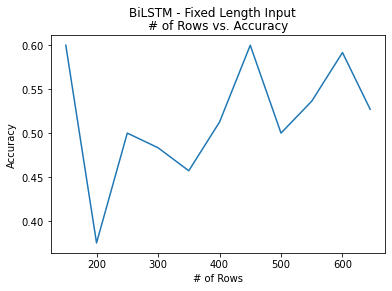

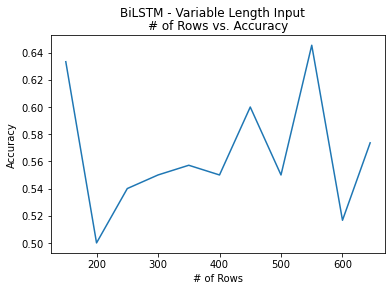

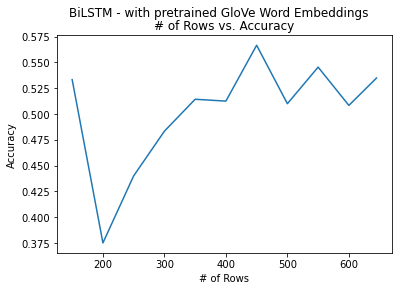

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(file_size, accuracy_fixed)
plt.title('# of Rows vs. Accuracy')
plt.suptitle('BiLSTM - Fixed Length Input')
plt.xlabel('# of Rows')
plt.ylabel('Accuracy')
plt.show()

plt.plot(file_size, accuracy_variable)
plt.title('# of Rows vs. Accuracy')
plt.suptitle('BiLSTM - Variable Length Input')
plt.xlabel('# of Rows')
plt.ylabel('Accuracy')
plt.show()

plt.plot(file_size, accuracy_glove)
plt.title('# of Rows vs. Accuracy')
plt.suptitle('BiLSTM - with pretrained GloVe Word Embeddings')
plt.xlabel('# of Rows')
plt.ylabel('Accuracy')
plt.show()



## Conclusions

- The model with the best performance is <b>BiLSTM - with pretrained GloVe Word Embeddings</b>, as we can see that it
has a most stable performance as the model is trained with more data.
- The model reaches an approximated Accuracy of 60% for the selected model, and it will probably improve when it is trained with a
bigger dataset.
- It is important to see that the first iteration with the smallest dataset with 150 rows reaches a high accuracy. This
is happening because over-fitting caused by too few rows, but the accuracy starts to show a more real behavior with bigger
datasets.